In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import ta

# Download historical data for SPY
spy_data = yf.download('SPY', start='2010-01-01', end='2023-12-31')

# Reset index to make Date a column
spy_data.reset_index(inplace=True)

# Select relevant features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
spy_data = spy_data[features]

spy_data['EMA12'] = spy_data['Adj Close'].ewm(span=12, adjust=False).mean()
spy_data['EMA26'] = spy_data['Adj Close'].ewm(span=26, adjust=False).mean()
spy_data['MACD'] = spy_data['EMA12'] - spy_data['EMA26']  # MACD line
spy_data['Signal_Line'] = spy_data['MACD'].ewm(span=9, adjust=False).mean()  # Signal line
spy_data['MACD_Histogram'] = spy_data['MACD'] - spy_data['Signal_Line']  # MACD Histogram

# CCI (Commodity Channel Index)
typical_price = (spy_data['High'] + spy_data['Low'] + spy_data['Adj Close']) / 3
mean_deviation = lambda x: np.mean(np.abs(x - x.mean()))
spy_data['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).apply(mean_deviation))

# ATR (Average True Range)
high_low = spy_data['High'] - spy_data['Low']
high_close = np.abs(spy_data['High'] - spy_data['Adj Close'].shift())
low_close = np.abs(spy_data['Low'] - spy_data['Adj Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
spy_data['ATR'] = true_range.rolling(window=14).mean()

# Bollinger Bands (BOLL)
spy_data['20_MA'] = spy_data['Adj Close'].rolling(window=20).mean()
spy_data['20_STD'] = spy_data['Adj Close'].rolling(window=20).std()
spy_data['Upper_Band'] = spy_data['20_MA'] + (2 * spy_data['20_STD'])
spy_data['Lower_Band'] = spy_data['20_MA'] - (2 * spy_data['20_STD'])

# EMA20 (20-day Exponential Moving Average)
spy_data['EMA20'] = spy_data['Adj Close'].ewm(span=20, adjust=False).mean()

# MA5 and MA10 (5-day and 10-day Simple Moving Averages)
spy_data['MA5'] = spy_data['Adj Close'].rolling(window=5).mean()
spy_data['MA10'] = spy_data['Adj Close'].rolling(window=10).mean()

# MTM6 and MTM12 (6-month and 12-month Momentum)
spy_data['MTM6'] = spy_data['Adj Close'].pct_change(periods=126)  # Approx. 6 months
spy_data['MTM12'] = spy_data['Adj Close'].pct_change(periods=252)  # Approx. 12 months

# ROC (Rate of Change)
spy_data['ROC'] = spy_data['Adj Close'].pct_change(periods=10) * 100  # 10-day rate of change

# SMI (Stochastic Momentum Index)
low_min = spy_data['Low'].rolling(window=14).min()
high_max = spy_data['High'].rolling(window=14).max()
spy_data['SMI'] = 100 * ((spy_data['Adj Close'] - low_min) / (high_max - low_min))

# WVAD (Williams's Variable Accumulation/Distribution)
spy_data['WVAD'] = ((spy_data['Adj Close'] - spy_data['Low']) - (spy_data['High'] - spy_data['Adj Close'])) / (spy_data['High'] - spy_data['Low']) * spy_data['Volume']

spy_data['Daily_Return'] = spy_data['Adj Close'].pct_change()

# Drop NaN values
spy_data.dropna(inplace=True)

print(spy_data.head())

# Convert to NumPy array
data = spy_data.values
print("Dataset shape:", data.shape)  # (num_days, num_features)
print(data)


[*********************100%***********************]  1 of 1 completed

Price         Open        High         Low  Adj Close     Volume      EMA12  \
Ticker         SPY         SPY         SPY        SPY        SPY              
252     126.709999  127.599998  125.699997  98.665184  138725200  97.366556   
253     127.330002  127.370003  126.190002  98.610832  137409700  97.557983   
254     126.580002  127.720001  126.459999  99.123367  133975300  97.798811   
255     127.690002  127.830002  127.010002  98.929237  122519000  97.972723   
256     127.559998  127.769997  126.150002  98.735085  156034600  98.090009   

Price       EMA26      MACD Signal_Line MACD_Histogram  ... Lower_Band  \
Ticker                                                  ...              
252     96.159599  1.206957    1.194114       0.012842  ...  94.557752   
253     96.341172  1.216811    1.198654       0.018157  ...  94.782006   
254     96.547261  1.251551    1.209233       0.042318  ...  94.999100   
255     96.723703  1.249020    1.217190       0.031829  ...  95.233400   
25

In [3]:
def create_sequences_with_target(data, time_steps, target_column):
    """
    Create sequences and separate target class.

    Args:
    - data: NumPy array of shape (num_days, num_features).
    - time_steps: Number of days per sequence.
    - target_column: Column index for the target variable.

    Returns:
    - X: Input sequences of shape (num_samples, time_steps, num_features-1).
    - y: Target values of shape (num_samples,).
    """
    sequences = []
    targets = []

    for i in range(len(data) - time_steps):
        # Extract a sequence of `time_steps` (excluding the target column)
        sequence = np.delete(data[i:i + time_steps], target_column, axis=1)
        sequences.append(sequence)

        # Extract the target value at the end of the sequence
        target = data[i + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences with 30 time steps and separate target (Daily_Return is the last column)
time_steps = 20
target_column = 24  # Assuming 'Daily_Return' is the 6th column (index 5)

X, y = create_sequences_with_target(data, time_steps, target_column)

print("Shape of X:", X.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y.shape)  # (num_samples,)


Shape of X: (3250, 20, 24)
Shape of y: (3250,)


In [4]:
from sklearn.preprocessing import StandardScaler

# Flatten the data to 2D for normalization
num_samples, time_steps, num_features = X.shape
X_flat = X.reshape(-1, num_features)  # Shape: (samples * time_steps, num_features)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler and transform the data
X_standardized_flat = scaler.fit_transform(X_flat)

# Reshape back to the original 3D shape
X_standardized = X_standardized_flat.reshape(num_samples, time_steps, num_features)

print("Shape of X_standardized:", X_standardized.shape)  # (num_samples, time_steps, num_features)

X = X_standardized


Shape of X_standardized: (3250, 20, 24)


In [5]:
from sklearn.model_selection import train_test_split

# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

print("Shape of X_train:", X_train.shape)  # Training features
print("Shape of X_val:", X_val.shape)      # Validation features
print("Shape of y_train:", y_train.shape)  # Training targets
print("Shape of y_val:", y_val.shape)      # Validation targets


Shape of X_train: (2600, 20, 24)
Shape of X_val: (650, 20, 24)
Shape of y_train: (2600,)
Shape of y_val: (650,)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def create_bidirectional_lstm(input_shape=(30,5), units=256, dropout_rate=0.2):
    
    model = Sequential()

    # Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape))
    # Dropout for regularization
    model.add(Dropout(dropout_rate))

    model.add(Bidirectional(LSTM(units // 2, return_sequences=True)))
    model.add(Dropout(dropout_rate))

    model.add(Bidirectional(LSTM(units // 4, return_sequences=False)))
    model.add(Dropout(dropout_rate))

    # Dense output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

    # Set a custom learning rate
    learning_rate = 0.0001  # Default for Adam is 0.001, adjust as needed
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


Epoch 1/50


/opt/anaconda3/envs/sp500/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0067 - mae: 0.0633 - val_loss: 0.0046 - val_mae: 0.0567
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0034 - mae: 0.0454 - val_loss: 8.3825e-04 - val_mae: 0.0239
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0022 - mae: 0.0354 - val_loss: 9.1130e-04 - val_mae: 0.0247
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.0018 - mae: 0.0326 - val_loss: 5.4329e-04 - val_mae: 0.0191
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0016 - mae: 0.0308 - val_loss: 0.0010 - val_mae: 0.0257
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 5.6437e-04 - val_mae: 0.0195
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.0012 - mae: 0.0263 - val_loss: 0.0018 - val_mae: 0.0368
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 7.9446e-04 - val_mae: 0.0240
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/st

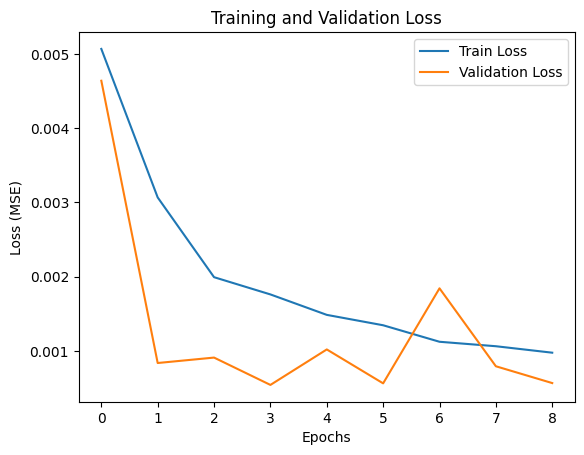

In [7]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

# Create the model
model = create_bidirectional_lstm(input_shape=input_shape)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust as needed
    batch_size=64,  # Adjust as needed
    verbose=1,  # 1 shows progress after each epoch
    callbacks=[early_stopping]  # Include early stopping
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation MAE: {val_mae}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [8]:
import numpy as np
import pandas as pd

# Predict returns for the validation set
y_pred = model.predict(X_val).flatten()  # Predicted returns (flattened to 1D)
y_true = y_val  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for pred_return, true_return in zip(y_pred, y_true):
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    daily_return = true_return if position == 1 else 0
    strategy_returns.append(daily_return)

    # Update cumulative return
    cumulative_return *= (1 + daily_return)

# Convert strategy returns to a DataFrame for analysis
strategy_df = pd.DataFrame({
    "True Return": y_true,
    "Predicted Return": y_pred,
    "Strategy Return": strategy_returns
})

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Cumulative Return: 4.26%


In [9]:
# Calculate true cumulative return (buy-and-hold strategy)
true_cumulative_return = np.prod(1 + y_true) - 1  # Compounded return

# Calculate strategy cumulative return
strategy_cumulative_return = np.prod(1 + np.array(strategy_returns)) - 1  # Compounded return

print(f"True Buy-and-Hold Cumulative Return: {true_cumulative_return:.2%}")
print(f"Strategy Cumulative Return: {strategy_cumulative_return:.2%}")


True Buy-and-Hold Cumulative Return: 18.02%
Strategy Cumulative Return: 4.26%


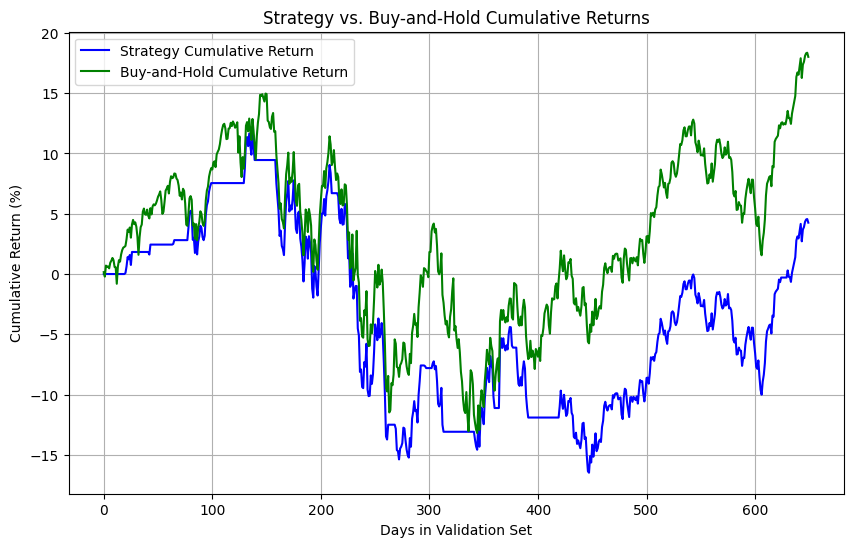

In [10]:
# Calculate cumulative returns for plotting
strategy_cumulative = (np.cumprod(1 + np.array(strategy_returns)) - 1) * 100
true_cumulative = (np.cumprod(1 + y_true) - 1) * 100

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative, label="Strategy Cumulative Return", color='blue')
plt.plot(true_cumulative, label="Buy-and-Hold Cumulative Return", color='green')
plt.xlabel("Days in Validation Set")
plt.ylabel("Cumulative Return (%)")
plt.title("Strategy vs. Buy-and-Hold Cumulative Returns")
plt.legend()
plt.grid()
plt.show()


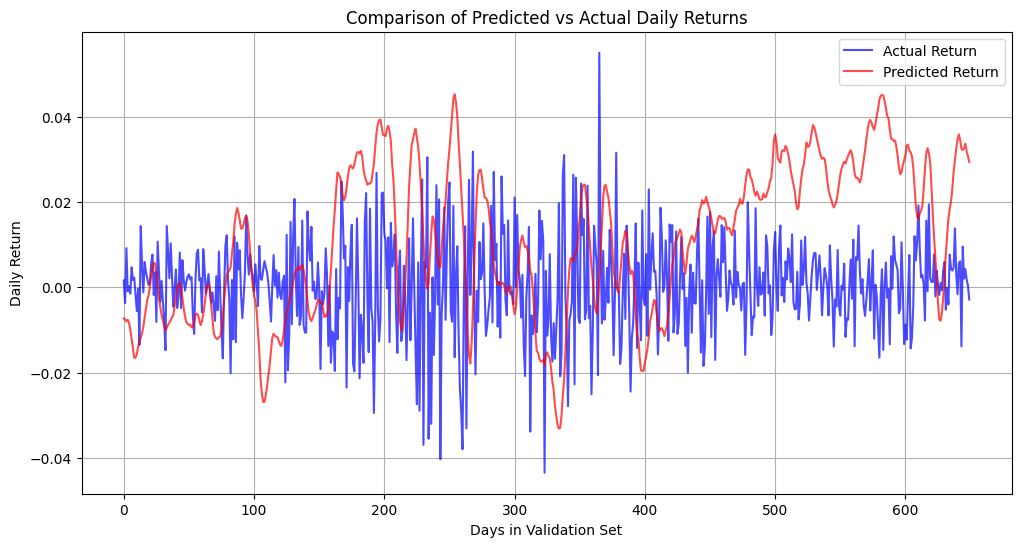

In [11]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual returns
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Return', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Return', color='red', alpha=0.7)
plt.xlabel("Days in Validation Set")
plt.ylabel("Daily Return")
plt.title("Comparison of Predicted vs Actual Daily Returns")
plt.legend()
plt.grid()
plt.show()


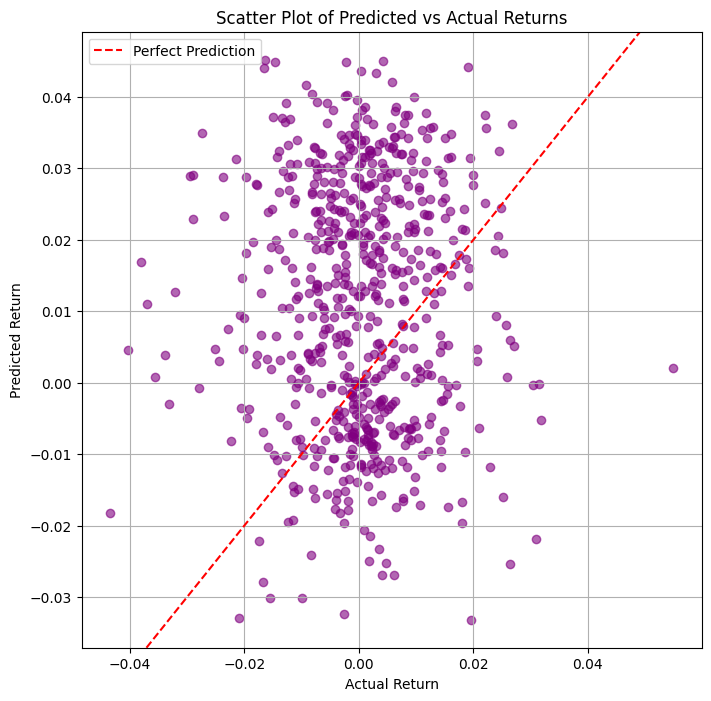

In [12]:
import numpy as np

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.6, color='purple')
plt.axline((0, 0), slope=1, color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Actual Return")
plt.ylabel("Predicted Return")
plt.title("Scatter Plot of Predicted vs Actual Returns")
plt.legend()
plt.grid()
plt.show()


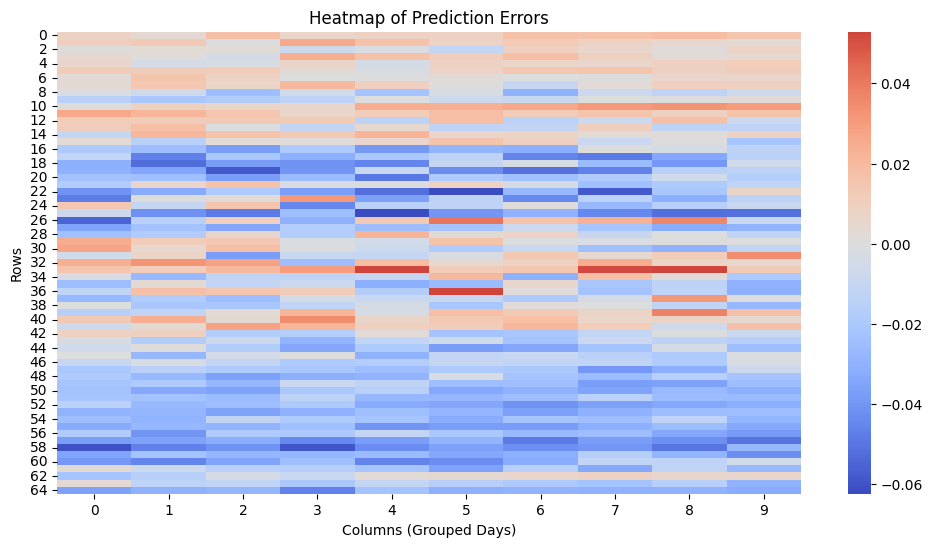

In [13]:
import seaborn as sns
import numpy as np

# Reshape for visualization (if needed)
error_matrix = np.reshape(y_val - y_pred, (-1, 10))  # Example: Reshape into 10 columns

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(error_matrix, cmap="coolwarm", center=0)
plt.title("Heatmap of Prediction Errors")
plt.xlabel("Columns (Grouped Days)")
plt.ylabel("Rows")
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
correlation = np.corrcoef(y_val, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Correlation Coefficient: {correlation:.2f}")


Mean Squared Error (MSE): 0.000543
Mean Absolute Error (MAE): 0.019118
Correlation Coefficient: 0.01
